In [18]:
!pip install torchmetrics==0.10

In [19]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
import time
import os

import cv2
from torchmetrics import F1Score
import pickle

In [20]:
path = '/kaggle/input/traffic-sign-datasets/'
path_dataset1 = path+'Indian Traffic Signs Prediction(85 classes)/Indian Traffic Signs Prediction(85 classes)/'
path_dataset2 = path+'Persian Traffic Sign Dataset (PTSD)/Persian Traffic Sign Dataset (PTSD)/'
path_dataset3 = path+'Traffic Signs (GTSRB plus 162 custom classes)/Traffic Signs (GTSRB plus 162 custom classes)/Data_images/'

savepath='/kaggle/working/'

**Data Loaders**

---



In [21]:
def load_data(path_train, val_split, path_test, batch_size, input_size):
  
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    transform_train= transforms.Compose([transforms.Resize(input_size),
                                         transforms.ColorJitter(brightness=(0.5,1.2), contrast=0, saturation=0, hue=0),
                                         transforms.RandomHorizontalFlip(),
#                                          transforms.RandomVerticalFlip(),
                                          transforms.RandomRotation(45),
                                        transforms.RandomAdjustSharpness(0.8),
                                          transforms.ToTensor(),
                                          normalize
                                          ])

    transform_test = transforms.Compose([transforms.Resize(input_size),
                                         transforms.ToTensor(), 
                                         normalize])

    data_train = datasets.ImageFolder(root=path_train, transform=transform_train)
    data_test = datasets.ImageFolder(root=path_test, transform=transform_test)
    
    mappings = data_train.class_to_idx

    val_size = int(len(data_train)*val_split)
    train_size = len(data_train) - val_size

    train_dataset, val_dataset = td.random_split(data_train, [train_size, val_size])
    
    data_loader_train = td.DataLoader(train_dataset,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      drop_last=False,
                                      num_workers=0,       
                                      pin_memory=True)
     
    data_loader_val = td.DataLoader(val_dataset,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=False,
                                    num_workers=0) 
      
    data_loader_test = td.DataLoader(data_test,
                                   batch_size=batch_size,
                                   shuffle=True,
                                   drop_last=False,
                                   num_workers=0)
    
    return data_loader_train, data_loader_test, data_loader_val, mappings

Compute Class Weights

In [22]:
def get_image_size_dist(path):
    t1 = time.time()

    folders = os.listdir(path)
    total = 0

    class_samples = {}

    for folder in folders:
        samples = os.listdir(path+folder)

        class_samples[folder]=len(samples)

        print("Class: {} has samples: {} ".format(folder,len(samples)))
        total+=len(samples)

    print("\nTotal number of samples: ",total)

    print("\nTime taken: {}".format(time.time()-t1))

    return class_samples, total

In [23]:
def get_class_weights(path_train, mappings):

    class_samples, total = get_image_size_dist(path_train)

    class_weights = [0]*len(mappings.keys())

    for key in mappings.keys():
        class_weights[mappings[key]] = 1 - (class_samples[key]/ total)
      
    return class_weights

In [24]:
num_epochs = 10

def get_criterion(class_weights):

    criterion = nn.CrossEntropyLoss(weight = class_weights)

    return criterion

In [25]:
def train_model(model, num_epochs, train_loader, criterion, optimizer, savepath, savepath_results, device):

      total_steps = len(train_loader)

      t1 = time.time()

      Mean_loss=[]
      train_accuracy=[]

      for epoch in range(num_epochs):
          correct=0
          total=0
          train_loss=0
          for i, data in enumerate(train_loader):
              
              images, labels = data[0].to(device), data[1].to(device)
              
              model.train()

              # Forward pass
              outputs = model(images)
              loss = criterion(outputs, labels)
              
              # Backprop and optimisation
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              
              # Train accuracy
              total += labels.size(0)
              _, predicted = torch.max(outputs.data, 1)
              correct += (predicted == labels).sum().item()
              
              train_loss += loss.item()*labels.size(0)
          
        
          mloss = train_loss/total
          if mloss > 3:
                mloss = mloss - (int)(mloss - 3)
                
          print('Epoch [{}/{}], Mean Loss: {:.4f}, Accuracy: {:.2f}%'
          .format(epoch + 1, num_epochs, mloss,
              (correct / total) * 100))

          Mean_loss.append(mloss)
          train_accuracy.append((correct / total) * 100)
                      
                  
      print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

#       print("/n/n Saving model at: ",savepath)
      torch.save(model.state_dict(), savepath)

      results = { "Mean_loss": Mean_loss, "accuracy": train_accuracy }

      with open(savepath_results, "wb") as fp:
          pickle.dump(results, fp)

      return model, device, train_accuracy, Mean_loss

In [27]:
nclasses=12

In [28]:
def get_model():
    AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=False)
    
    prev_out = AlexNet_model.classifier[4].out_features
    AlexNet_model.classifier[6] = nn.Linear( prev_out, nclasses)
    
    return AlexNet_model

Grid Search: Learning rate

In [29]:
path_train = path_dataset2+"train/"
path_test = path_dataset2+"test/"
val_split = 0.2
batch_size = 32
input_size = (224,224)

train_loader, test_loader, val_loader, mappings = load_data(path_train, val_split, path_test, batch_size, input_size)

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

Device: cuda:0


In [31]:
class_weights = get_class_weights(path_train, mappings)

class_weights = torch.FloatTensor(class_weights)
class_weights = class_weights.to(device)

criterion = get_criterion(class_weights)

Class: Pedestrain has samples: 1014 
Class: NO Stopping has samples: 1075 
Class: Right Turn Prohibited has samples: 436 
Class: Danger has samples: 399 
Class: Compulsory Keep BothSide has samples: 573 
Class: Maximum Speed 30 has samples: 477 
Class: Right Margin has samples: 506 
Class: Cycle crossing has samples: 662 
Class: Roundabouts has samples: 497 
Class: One way Traffic has samples: 684 
Class: Compulsory Keep Right has samples: 703 
Class: No Entry has samples: 930 

Total number of samples:  7956

Time taken: 0.009218931198120117


In [32]:
model_savepath = savepath+"alexnetmodel_d2"
savepath_results= savepath+"htuning_results"

hyper_parameters={}
hyper_parameters["learning_rate"] = [0.01, 0.001, 0.0001]

train_loss_hyper_paramaters = {}
train_acc_hyper_paramaters={}

for learning_rate in hyper_parameters["learning_rate"]:
    
    print(f'Results of the learning rate = {learning_rate}')
        
    results = savepath_results+'_lr'+str(learning_rate)+".pkb"
    model_path = model_savepath + '_lr'+str(learning_rate)+".pt"
    
    AlexNet_model = get_model()
    
    AlexNet_model.to(device)
    
    optimizer = torch.optim.Adam(AlexNet_model.parameters(), lr=learning_rate)

    trained_AlexNet_model, device, train_accuracy, train_loss = train_model(AlexNet_model, num_epochs, train_loader, criterion, optimizer,model_path, results, device)

    train_loss_hyper_paramaters['lr'+str(learning_rate)] = train_loss
    train_acc_hyper_paramaters['lr'+str(learning_rate)] = train_accuracy


Results of the learning rate = 0.01


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch [1/10], Mean Loss: 3.8956, Accuracy: 10.95%
Epoch [2/10], Mean Loss: 3.4805, Accuracy: 12.58%
Epoch [3/10], Mean Loss: 3.1275, Accuracy: 13.48%
Epoch [4/10], Mean Loss: 2.6020, Accuracy: 13.31%
Epoch [5/10], Mean Loss: 2.4914, Accuracy: 13.34%
Epoch [6/10], Mean Loss: 2.5657, Accuracy: 13.04%
Epoch [7/10], Mean Loss: 2.5089, Accuracy: 13.17%
Epoch [8/10], Mean Loss: 2.4776, Accuracy: 13.20%
Epoch [9/10], Mean Loss: 2.4720, Accuracy: 13.35%
Epoch [10/10], Mean Loss: 2.4677, Accuracy: 13.17%
######## Training Finished in 601.8073451519012 seconds ###########
Results of the learning rate = 0.001


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch [1/10], Mean Loss: 1.8776, Accuracy: 30.04%
Epoch [2/10], Mean Loss: 0.7097, Accuracy: 75.96%
Epoch [3/10], Mean Loss: 0.4437, Accuracy: 86.85%
Epoch [4/10], Mean Loss: 0.3334, Accuracy: 90.95%
Epoch [5/10], Mean Loss: 0.3267, Accuracy: 90.76%
Epoch [6/10], Mean Loss: 0.2509, Accuracy: 92.99%
Epoch [7/10], Mean Loss: 0.2709, Accuracy: 92.90%
Epoch [8/10], Mean Loss: 0.2473, Accuracy: 93.39%
Epoch [9/10], Mean Loss: 0.1876, Accuracy: 94.96%
Epoch [10/10], Mean Loss: 0.1823, Accuracy: 95.35%
######## Training Finished in 594.6429646015167 seconds ###########
Results of the learning rate = 0.0001


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch [1/10], Mean Loss: 2.0992, Accuracy: 24.21%
Epoch [2/10], Mean Loss: 1.4763, Accuracy: 44.98%
Epoch [3/10], Mean Loss: 1.0672, Accuracy: 62.03%
Epoch [4/10], Mean Loss: 0.7938, Accuracy: 72.22%
Epoch [5/10], Mean Loss: 0.6179, Accuracy: 78.90%
Epoch [6/10], Mean Loss: 0.5266, Accuracy: 82.55%
Epoch [7/10], Mean Loss: 0.4307, Accuracy: 86.63%
Epoch [8/10], Mean Loss: 0.3912, Accuracy: 87.51%
Epoch [9/10], Mean Loss: 0.3348, Accuracy: 89.08%
Epoch [10/10], Mean Loss: 0.2837, Accuracy: 91.58%
######## Training Finished in 595.323992729187 seconds ###########


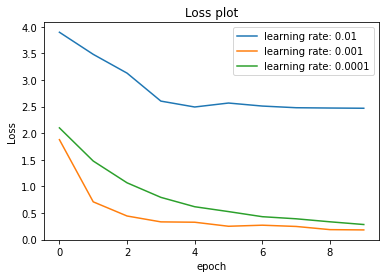

In [33]:
####### plot the the training loss here #########

epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss plot')

for learning_rate in hyper_parameters["learning_rate"]:

    plt.plot(epochs,train_loss_hyper_paramaters[f'lr{learning_rate}'],label=f'learning rate: {learning_rate}')
    
plt.legend()

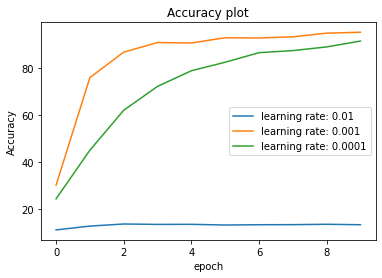

In [34]:
####### plot the the training accuracies here #########

epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')

for learning_rate in hyper_parameters["learning_rate"]:

    plt.plot(epochs,train_acc_hyper_paramaters[f'lr{learning_rate}'],label=f'learning rate: {learning_rate}')
    
plt.legend()